Authors:

Juan Pablo Enríquez Pedroza 0228903

Ulises Gallardo Rodríguez   0229261

## Functions

In [449]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random

In [450]:
calls = 0 #Total calls of objetive function
idx_valid_to_change = []

In [451]:
def read_csv(path):
  df = pd.read_csv(path, header=None)
  sudoku = df.to_numpy()
  return sudoku

In [452]:
def get_population(n, matrix):
  r,c = matrix.shape
  population = np.zeros([n, r, c], dtype = "int32")
  permutation = []
  left = set(list(range(10)))
  for row in range(r):
    permutation.append(set(left-set(matrix[row])))

  for i in range(n): 
    population[i] = matrix
    for row in range(r):
      aux_left = list(permutation[row])
      idx = np.where(matrix[row]==0)[0]
      idx_valid_to_change.append(idx)
      aux_left = np.random.permutation(aux_left)
      population[i][row][idx] = aux_left
  return population

In [453]:
def f(sudoku):
  global calls
  calls+=1
  cost = 0
  aux = np.array(sudoku)
  aux = aux.transpose()

  box = np.zeros([9,9], dtype='int8')
  con = 0
  fila = 0
  for i in range(0,9):
    if con%3 == 0 and con!=0:
      con = 0
      fila+=3
    for j in range(0,9):
      if j<=2: box[fila][j%3 + 3*(con)] = sudoku[i][j]
      if j>2 and j<=5: box[fila+1][j%3 + 3*(con)] = sudoku[i][j]
      if j>5: box[fila+2][j%3 + 3*(con)] = sudoku[i][j] 
    con+=1
  
  for row in range(len(aux)):
    for x in range(1,10):
      repeated = np.count_nonzero(aux[row] == (x))
      if repeated>1:
        cost+=((repeated-1))

      rep = np.count_nonzero(box[row] == (x))
      if rep >1:
        cost+=(rep-1)


  return cost

In [454]:
def plot_solution(individual, title, board_size = 9):
  matrix = np.zeros((board_size,board_size))
  colors = np.zeros((board_size,board_size))
  color_ = 0 #negro
  for i in range(9):
    if (i)%3==0: color_ = 1-color_
    for j in range(9):
      matrix[i][j] = color_
      colors[i][j] = color_
      if (j+1)%3 ==0:
        color_ = 1 - color_
    color_ = 1 - color_
  plt.title(title)
  plt.imshow(matrix, cmap='binary')
  for i in range(len(individual)):
    for j in range(len(individual[i])):
      plt.text(j,i, str(int(individual[i][j])) if individual[i][j]>0 else "", fontsize=15, ha='center', va='center', color='white' if (colors[i][j]==1) else 'black')
  plt.show()

## Selection

In [455]:
def roulette_selection(fitness):
  range_probability = np.zeros((len(fitness), 2))
  range_probability[0][0]=0
  total = np.sum(fitness)

  new_total = 0
  aux = fitness.copy()
  for i in range(len(aux)):
    aux[i] = total - fitness[i]
    new_total += aux[i]

  for i in range(len(aux)):
    PN = (aux[i])/new_total
    if i>0:
      range_probability[i][0] = range_probability[i-1][1]
      range_probability[i][1] = range_probability[i-1][1]+PN
    else:
      range_probability[i][0] = 0
      range_probability[i][1] = PN
  p = np.random.random() 
  #print(range_probability)
  for i in range(len(range_probability)):
    if p >=range_probability[i][0] and p<range_probability[i][1]:
      return i


In [456]:
def tournament_selection(fitness, k = 2):
  parents = random.sample(range(0, len(fitness)), k)
  winner = np.argmin(fitness[parents])
  return(parents[winner])

## Mutation

In [457]:
def swap_mutation(individual):
  global idx_valid_to_change

  row = np.random.randint(0,9)
  idx = idx_valid_to_change[row]
  x,y = -1,-1
  while x==y:
    x = np.random.choice(idx, size=1)
    y = np.random.choice(idx, size=1)

  individual[row][x], individual[row][y] = individual[row][y], individual[row][x]
    
  return individual

In [458]:
def mutate(Population, Pm): 
  for i in range(len(Population)):
    p = np.random.random()
    if p < Pm:
      Population[i] = np.copy(swap_mutation(Population[i]))

  return Population

## Crossover

In [459]:
def simple_permutation_crossover(parentA, parentB, Begin):
  offspring = np.zeros(parentA.shape, dtype = np.chararray)
  offspring[:int(len(parentA)/Begin)] = parentA[:int(len(parentA)/Begin)]
  offspring[int(len(parentA)/Begin):] = parentB[int(len(parentA)/Begin):]
  return offspring

In [460]:
def crossover(population,fitness,pop_size, Pr):
  n,r,c = population.shape
  offspring = np.zeros([n,r,c])

  for i in range(offspring.shape[0]):
    p = np.random.random()
    if p < Pr:
      parentA = (tournament_selection(fitness))
      parentB = (tournament_selection(fitness))

      n = np.random.choice(range(1,9-1), size=1)
      offspring[i] = np.copy(simple_permutation_crossover(np.copy(population[parentA]), np.copy(population[parentB]),n))
    else:
      parent = np.copy(tournament_selection(fitness))
      offspring[i] = np.copy(population[parent])
      
  return offspring

## Algorithm

In [461]:
def genetic_algorithm(pop_size = 30, G = 100, Pr = 0.8, Pm = 0.3):
  original = read_csv("input04.csv")
  plot_solution(original,"ORIGINAL")
  population = get_population(pop_size, original)

  fitness = np.zeros(pop_size)
  elite = np.zeros(2)
  g = 0

  for i, individual in enumerate(population):
    fitness[i] = f(individual)
  
  elite = [min(fitness), np.copy(population[np.argmin(fitness)])]
  
  while g < G:
    population = np.copy(crossover(population,fitness,pop_size, Pr))
    population = np.copy(mutate(population,Pm))
    
    for i, individual in enumerate(population):
      fitness[i] = f(individual)
   
    actual_elite = [min(fitness), np.copy(population[np.argmin(fitness)])]
    
    if actual_elite[0] < elite[0]:
      elite = np.copy(actual_elite)
    else:
      population[np.argmin(fitness)] = np.copy(elite[1])
    
    if(int(actual_elite[0]) == 0): break

    g += 1
    print("Generation:", g)
    #print("Avg", np.sort(fitness))
    print("Elite ",g," : ",elite[0])
  print("TOTAL CALLS TO OBJETIVE FUNCTION: ", calls)
  print("SOLUTION:")
  plot_solution(elite[1], "SOLUTION with " + str(int(elite[0])) +" error")


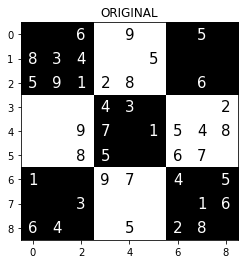

Generation: 1
Elite  1  :  32.0
Generation: 2
Elite  2  :  30.0
Generation: 3
Elite  3  :  30.0
Generation: 4
Elite  4  :  29.0
Generation: 5
Elite  5  :  29.0
Generation: 6
Elite  6  :  27.0
Generation: 7
Elite  7  :  27.0
Generation: 8
Elite  8  :  27.0
Generation: 9
Elite  9  :  26.0
Generation: 10
Elite  10  :  26.0
Generation: 11
Elite  11  :  23.0
Generation: 12
Elite  12  :  23.0


c:\Users\Ulises\anaconda3\lib\site-packages\numpy\lib\function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


Generation: 13
Elite  13  :  23.0
Generation: 14
Elite  14  :  22.0
Generation: 15
Elite  15  :  22.0
Generation: 16
Elite  16  :  22.0
Generation: 17
Elite  17  :  21.0
Generation: 18
Elite  18  :  21.0
Generation: 19
Elite  19  :  21.0
Generation: 20
Elite  20  :  21.0
Generation: 21
Elite  21  :  19.0
Generation: 22
Elite  22  :  19.0
Generation: 23
Elite  23  :  19.0
Generation: 24
Elite  24  :  19.0
Generation: 25
Elite  25  :  19.0
Generation: 26
Elite  26  :  19.0
Generation: 27
Elite  27  :  19.0
Generation: 28
Elite  28  :  17.0
Generation: 29
Elite  29  :  17.0
Generation: 30
Elite  30  :  17.0
Generation: 31
Elite  31  :  17.0
Generation: 32
Elite  32  :  17.0
Generation: 33
Elite  33  :  17.0
Generation: 34
Elite  34  :  17.0
Generation: 35
Elite  35  :  17.0
Generation: 36
Elite  36  :  17.0
Generation: 37
Elite  37  :  15.0
Generation: 38
Elite  38  :  15.0
Generation: 39
Elite  39  :  15.0
Generation: 40
Elite  40  :  15.0
Generation: 41
Elite  41  :  15.0
Generation: 42

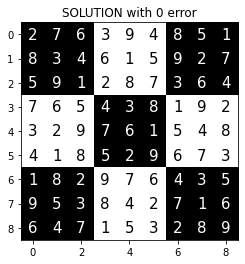

In [462]:
pop_size = 30         #Population size
G = 3000            #Number of generations
Pr = 0.9            #Reproduction probability
Pm = 0.25               #Mutation probability
genetic_algorithm(pop_size, G, Pr, Pm)